<a href="https://colab.research.google.com/github/RenatoMaximiano/Trabalho_ADP2/blob/main/stratificado__v3_balanceamento_red_wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Projeto final  Modelagem Preditiva e Descritiva I***

***Alunos:*** Bernardo Morales, Renato Maximiano.

***Banco de Dados:*** [Red-Wine-Quality](https://www.openml.org/search?type=data&status=active&qualities.NumberOfInstances=between_1000_10000&sort=runs&order=asc&id=43695)

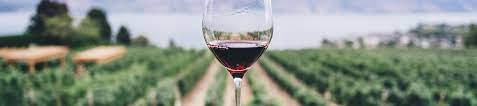

#***A atividade***

Selecionar um banco de dados do OpenML [openml](https://www.openml.org/)
     -- o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
     -- cada dupla deve informar qual banco de dados usará com antecedência
-- 10-fold cross-validation
-- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB, SVM, … 
-- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
-- para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar

O relatório final deve conter pelo menos as seguintes informações:
  1. Introdução
  2. Algoritmos de Aprendizagem de Máquina
  3. Experimentos
  3.1. Banco de dados
  3.2. Métricas
  3.3. Resultados 
  4. Conclusões
  Referências


#***Introdução***

Para este trabalho vamos utilizar o banco de dados Red-Wine-Quality, o conjunto de dados está relacionado com variantes tinto e branco do vinho português "Vinho Verde". Por questões de privacidade e logística, apenas variáveis físico-químicas (entradas) e sensoriais (saídas) estão disponíveis (por exemplo, não há dados sobre tipos de uva, marca de vinho, preço de venda do vinho etc.). Esses conjuntos de dados podem ser vistos como tarefas de classificação ou regressão. As classes são ordenadas e não equilibradas (por exemplo, há muito mais vinhos normais do que excelentes ou pobres).
Variáveis de entrada (com base em testes físico-químicos): 1 - acidez fixa 2 - acidez volátil 3 - ácido cítrico 4 - açúcar residual 5 - cloretos 6 - dióxido de enxofre livre 7 - dióxido de enxofre total 8 - densidade 9 - pH 10 - sulfatos 11 – álcool. Variável de saída (baseada em dados sensoriais): 12 - qualidade (pontuação entre 0 e 10).
Para facilitar as análises definimos 3 classes com base nas pontuações dos vinhos. De 0 até 5 (Ruim), igual a 6 (Regular), de 7 até 10 (Bom).  Para este trabalho utilizamos o Optuna como otimizador de hiper parâmetros. Também aplicamos um 10-fold cross-validation dentro de cada iteração, utilizando a melhor média de acurácia para escolher os melhores hiper parâmetros.


#***Fluxograma***
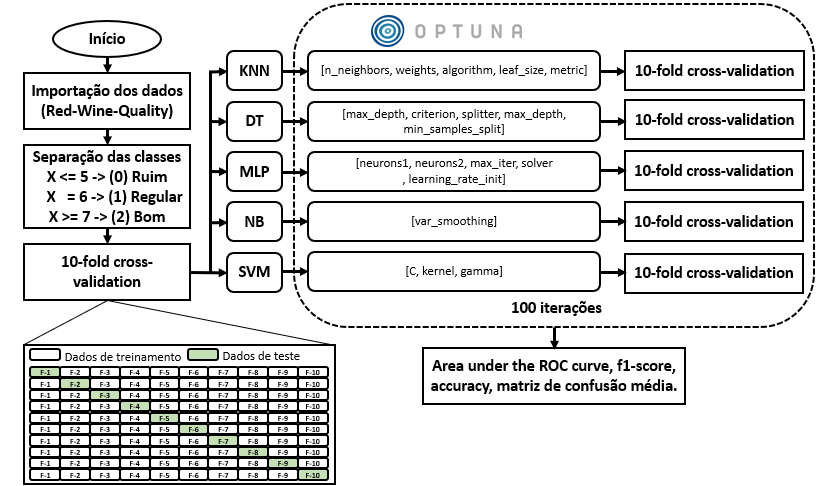

#***Bibliotecas utilizadas no projeto***

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from scipy.io.arff import loadarff 

#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.svm import SVC

#Funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, f1_score, plot_roc_curve, recall_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import Pipeline
import warnings
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler
import random as python_random
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')


In [ ]:
def reset_seeds():
   np.random.seed(4) 
   python_random.seed(9498)
   tf.random.set_seed(9)

reset_seeds() 

#***Banco de Dados***

Aqui é feito a importação dos dados, a separação das classes e as analises iniciais. 

In [ ]:
#Importação dos dados
raw_data = loadarff('/content/drive/MyDrive/Trabalho_APD/Red_wine')
df_data = pd.DataFrame(raw_data[0])

#Separação das classes.
df_data.loc[df_data["quality"] == 3, "quality"] = 0
df_data.loc[df_data["quality"] == 4, "quality"] = 0
df_data.loc[df_data["quality"] == 5, "quality"] = 0
df_data.loc[df_data["quality"] == 6, "quality"] = 1
df_data.loc[df_data["quality"] == 7, "quality"] = 2
df_data.loc[df_data["quality"] == 8, "quality"] = 2

#Analises iniciais
#df_data = df_data.apply(lambda x: x.str.decode('utf8'))
print("Quantas classes existem nesse dataset?\n%d" %(len(df_data["quality"].unique())))
print("\nQuantas instâncias existem no dataset?\n%d" %(len(df_data)))
print("\nQuantas features existem no dataset?\n%d" %(df_data.shape[1]))
print("\nQue features são essas?\n%s" %(str([k for k in df_data.keys()])))
print("\nQual o numero de instâncias por classe?")
print(df_data["quality"].value_counts())
dataset=df_data
df_data.head()

Quantas classes existem nesse dataset?
3

Quantas instâncias existem no dataset?
1599

Quantas features existem no dataset?
12

Que features são essas?
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Qual o numero de instâncias por classe?
0.0    744
1.0    638
2.0    217
Name: quality, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


#***Visualização de espaço de parâmetros***

Confrontando feature por feature.

In [ ]:
sns.pairplot(data=df_data, vars=('fixed_acidity',	'volatile_acidity',	'citric_acid',	'residual_sugar',
                               'chlorides',	'free_sulfur_dioxide',	'total_sulfur_dioxide',	'density',	'pH',	'sulphates',	'alcohol'), hue='quality', palette=sns.color_palette()[:3])

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2f03b9b830> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f2f03ba3320> (for post_execute):


KeyboardInterrupt: ignored

#***Separando o Dataset em 10-Fold*** 

Obtendo os índices de forma misturada e aleatória, para o conjunto de treinamento e teste. Onde sempre teremos 9 para treinamento  vs 1 para teste. 

In [ ]:
#Aqui os índices são obtidos, guardados em suas respectivas listas de treinamento e teste, para serem utilizados posteriormente.
dataset=df_data
Train_index = []
Test_index = []
kf = StratifiedKFold(n_splits=10, random_state=9, shuffle=True)
for train_index, test_index in kf.split(dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]],dataset.iloc[:,[11]]):
   Train_index.append(train_index)
   Test_index.append(test_index)

In [ ]:
#Dividindo os dados de entrada dos dados alvos de interesse. 
X = dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
y = dataset.iloc[:,[11]]
def Train_test_Kfold(n):
  #Separando o conjunto de dados em treinamento e teste
  global Xtrain, ytrain, Xtest, ytest
  Xtrain, ytrain, Xtest, ytest = X.iloc[Train_index[n]], y.iloc[Train_index[n]], X.iloc[Test_index[n]], y.iloc[Test_index[n]]

#***KNN (K-Nearest Neighbors)***

**********************0**********************
[2, 'uniform', 'kd_tree', 22, 'minkowski'] -> accuracy:0.68125 -> F1-Macro:0.6380795429575917recall score-macro:0.6475595238095238
**********************1**********************
[1, 'distance', 'ball_tree', 40, 'euclidean'] -> accuracy:0.7125 -> F1-Macro:0.6908747397954565recall score-macro:0.7101785714285714
**********************2**********************
[1, 'distance', 'ball_tree', 40, 'euclidean'] -> accuracy:0.6875 -> F1-Macro:0.6829194284872587recall score-macro:0.703924963924964
**********************3**********************
[2, 'uniform', 'ball_tree', 50, 'euclidean'] -> accuracy:0.65625 -> F1-Macro:0.632119355570683recall score-macro:0.6205483405483405
**********************4**********************
[2, 'distance', 'kd_tree', 29, 'manhattan'] -> accuracy:0.68125 -> F1-Macro:0.6655523389394357recall score-macro:0.6894963144963144
**********************5**********************
[1, 'distance', 'auto', 33, 'euclidean'] -> accuracy:0.63125 -> 

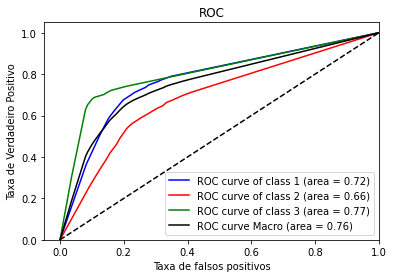

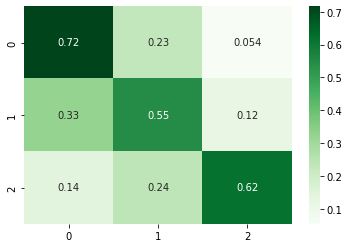

**********************0**********************
[10, 'distance', 'auto', 24, 'euclidean'] -> accuracy:0.55625 -> F1-Macro:0.5309849912972879recall score-macro:0.5830257936507937
**********************1**********************
[10, 'distance', 'ball_tree', 50, 'minkowski'] -> accuracy:0.6 -> F1-Macro:0.575444707797649recall score-macro:0.6400496031746031
**********************2**********************
[9, 'distance', 'auto', 21, 'euclidean'] -> accuracy:0.58125 -> F1-Macro:0.5623009137319936recall score-macro:0.6353920153920155
**********************3**********************
[13, 'distance', 'kd_tree', 29, 'minkowski'] -> accuracy:0.66875 -> F1-Macro:0.6364358579860728recall score-macro:0.6911399711399712
**********************4**********************
[23, 'distance', 'ball_tree', 50, 'minkowski'] -> accuracy:0.61875 -> F1-Macro:0.5917603585776818recall score-macro:0.6147113022113021
**********************5**********************
[17, 'uniform', 'auto', 46, 'minkowski'] -> accuracy:0.55 -> F1-Mac

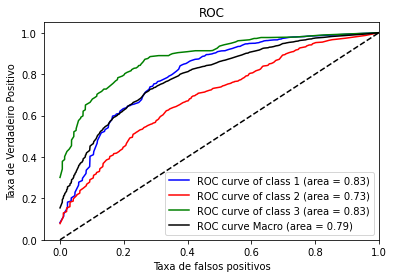

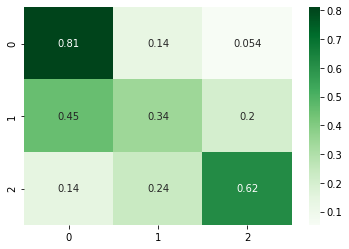

**********************0**********************
[14, 'distance', 'ball_tree', 26, 'manhattan'] -> accuracy:0.6625 -> F1-Macro:0.6466090741183523recall score-macro:0.7096428571428571
**********************1**********************
[3, 'distance', 'auto', 21, 'manhattan'] -> accuracy:0.6625 -> F1-Macro:0.6454552140793276recall score-macro:0.6822321428571428
**********************2**********************
[17, 'distance', 'kd_tree', 36, 'manhattan'] -> accuracy:0.625 -> F1-Macro:0.6294787290550002recall score-macro:0.6848292448292449
**********************3**********************
[1, 'uniform', 'ball_tree', 46, 'manhattan'] -> accuracy:0.7 -> F1-Macro:0.6690933402960747recall score-macro:0.6716786916786917
**********************4**********************
[4, 'distance', 'ball_tree', 26, 'manhattan'] -> accuracy:0.5875 -> F1-Macro:0.579491980736634recall score-macro:0.6162981162981163
**********************5**********************
[2, 'uniform', 'brute', 34, 'minkowski'] -> accuracy:0.6625 -> F1-Macr

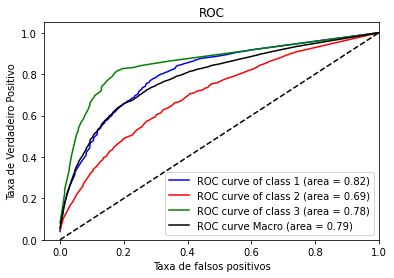

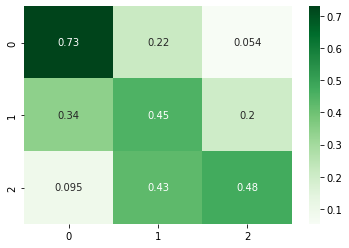

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import NearMiss
Sampler_list = [SMOTE(random_state = 9),NearMiss(),"SMOTE_Near"]

for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []
  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
            weights     = trial.suggest_categorical("weights", ['uniform', 'distance'])
            algorithm   = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
            leaf_size   = trial.suggest_int("leaf_size", 20, 50)
            metric      = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])

            #Modelo Utilizado -> KNN
            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, metric=metric)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [n_neighbors,weights,algorithm,leaf_size,metric]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["n_neighbors"])
          h_1.append(Importance["weights"])
          h_2.append(Importance["algorithm"])
          h_3.append(Importance["leaf_size"])
          h_4.append(Importance["metric"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("n_neighbors: %.2f%%, weights: %.2f%%, algorithm: %.2f%%, leaf_size: %.2f%%, metric: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***DT (Decision tree)***

**********************0**********************
[16, 'gini', 'random', 2, 1] -> accuracy:0.66875 -> F1-Macro:0.6432704481484969recall score-macro:0.6638194444444444
**********************1**********************
[16, 'entropy', 'best', 5, 1] -> accuracy:0.70625 -> F1-Macro:0.6676179604261797recall score-macro:0.6828769841269842
**********************2**********************
[19, 'entropy', 'random', 2, 1] -> accuracy:0.625 -> F1-Macro:0.6155220794565057recall score-macro:0.6338335738335737
**********************3**********************
[14, 'entropy', 'best', 2, 1] -> accuracy:0.725 -> F1-Macro:0.7092607709750567recall score-macro:0.7224242424242423
**********************4**********************
[16, 'gini', 'best', 2, 1] -> accuracy:0.66875 -> F1-Macro:0.6387603418251808recall score-macro:0.6364916052416052
**********************5**********************
[15, 'gini', 'best', 3, 1] -> accuracy:0.7 -> F1-Macro:0.663570281202851recall score-macro:0.6611256142506142
**********************6*******

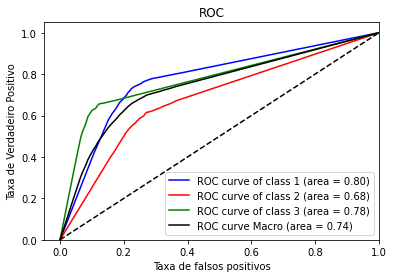

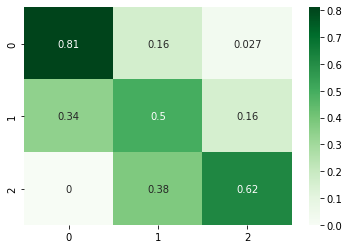

**********************0**********************
[13, 'entropy', 'best', 5, 3] -> accuracy:0.53125 -> F1-Macro:0.48741702741702736recall score-macro:0.5408630952380952
**********************1**********************
[17, 'gini', 'random', 5, 2] -> accuracy:0.58125 -> F1-Macro:0.5539885298456036recall score-macro:0.5939583333333333
**********************2**********************
[20, 'gini', 'random', 3, 3] -> accuracy:0.53125 -> F1-Macro:0.5068420675897312recall score-macro:0.5587012987012986
**********************3**********************
[19, 'entropy', 'best', 4, 3] -> accuracy:0.5875 -> F1-Macro:0.5543397198606083recall score-macro:0.5987012987012986
**********************4**********************
[12, 'gini', 'best', 2, 1] -> accuracy:0.4875 -> F1-Macro:0.45849477515557124recall score-macro:0.4896729115479115
**********************5**********************
[10, 'gini', 'best', 2, 3] -> accuracy:0.59375 -> F1-Macro:0.5553118270914249recall score-macro:0.5746954340704341
**********************6*

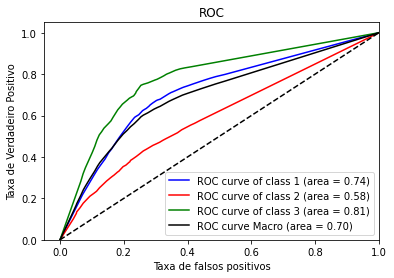

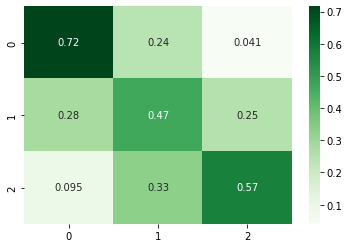

**********************0**********************
[17, 'gini', 'best', 2, 1] -> accuracy:0.6125 -> F1-Macro:0.5735948886233132recall score-macro:0.5956150793650793
**********************1**********************
[16, 'entropy', 'best', 3, 1] -> accuracy:0.7375 -> F1-Macro:0.7326739926739926recall score-macro:0.7645337301587302
**********************2**********************
[15, 'gini', 'best', 3, 1] -> accuracy:0.5875 -> F1-Macro:0.571875recall score-macro:0.5741991341991342
**********************3**********************
[18, 'entropy', 'best', 5, 1] -> accuracy:0.66875 -> F1-Macro:0.6427940346098914recall score-macro:0.664098124098124
**********************4**********************
[15, 'entropy', 'best', 2, 1] -> accuracy:0.59375 -> F1-Macro:0.5795582600856435recall score-macro:0.5988047706797707
**********************5**********************
[12, 'gini', 'best', 2, 1] -> accuracy:0.64375 -> F1-Macro:0.6140819964349377recall score-macro:0.6319359131859131
**********************6****************

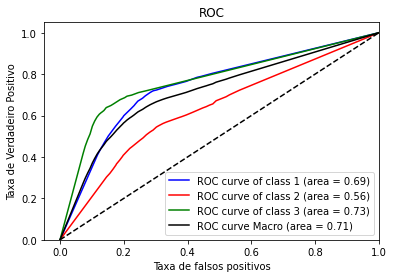

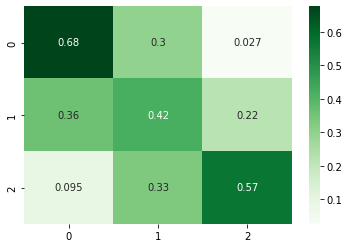

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para guardar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []

  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            max_depth = trial.suggest_int("max_depth", 10,20)
            criterion     = trial.suggest_categorical("criterion", ['gini', 'entropy'])
            splitter   = trial.suggest_categorical("splitter", ["best", "random"])
            min_samples_split   = trial.suggest_int("min_samples_split", 2,5)
            min_samples_leaf   = trial.suggest_int("min_samples_leaf", 1, 3)

            #Modelo Utilizado -> KNN
            model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [max_depth,criterion,splitter,min_samples_split,min_samples_leaf]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["max_depth"])
          h_1.append(Importance["criterion"])
          h_2.append(Importance["splitter"])
          h_3.append(Importance["min_samples_split"])
          h_4.append(Importance["min_samples_leaf"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("max_depth: %.2f%%, criterion: %.2f%%, splitter: %.2f%%, min_samples_split: %.2f%%, min_samples_leaf: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***GNB (Gaussian Naive Bayes)***

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.6125 -> F1-Macro:0.5775781850548206recall score-macro:0.6382738095238095
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5393027097004598recall score-macro:0.6034821428571429
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.525 -> F1-Macro:0.5048165426806204recall score-macro:0.592005772005772
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.59375 -> F1-Macro:0.5742512585578279recall score-macro:0.6468205868205869
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.5125 -> F1-Macro:0.5090381686008131recall score-macro:0.5566134316134316
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.4875 -> F1-Macro:0.4556759121005083recall score-macro:0.5031352375102375
**********************6**********************
[3.8079471765

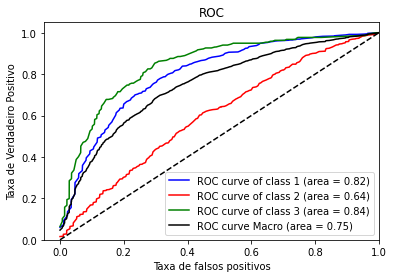

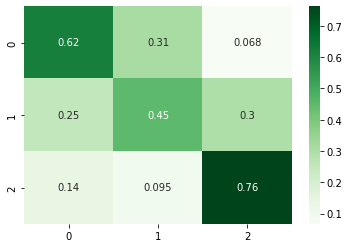

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.5 -> F1-Macro:0.45942665129139854recall score-macro:0.4881746031746032
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.45625 -> F1-Macro:0.43563429143529026recall score-macro:0.4890575396825397
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.40625 -> F1-Macro:0.3905242905242905recall score-macro:0.4523328523328523
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.48125 -> F1-Macro:0.44133644133644134recall score-macro:0.467070707070707
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.375 -> F1-Macro:0.34253990853774646recall score-macro:0.36529995904995904
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.46875 -> F1-Macro:0.44514456736678953recall score-macro:0.5009725634725635
**********************6**********************
[3.8079

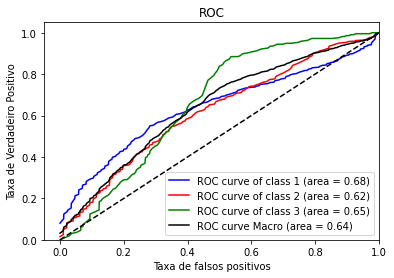

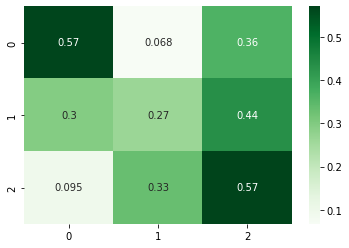

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.6 -> F1-Macro:0.5777220230983672recall score-macro:0.6316765873015874
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5206594418486441recall score-macro:0.5669047619047619
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5428504847129009recall score-macro:0.6319191919191919
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.60625 -> F1-Macro:0.5648201902918885recall score-macro:0.6300625300625301
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.55 -> F1-Macro:0.5120587508945941recall score-macro:0.5801213144963145
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.54375 -> F1-Macro:0.49311649311649325recall score-macro:0.5145500614250614
**********************6**********************
[3.80794717658

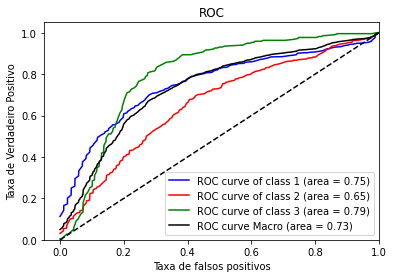

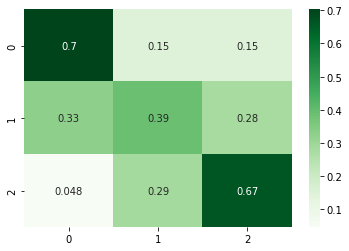

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-08)

            #Modelo Utilizado -> KNN
            model = GaussianNB(var_smoothing=var_smoothing)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [var_smoothing]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))

  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***MLP (Multilayer perceptron)***

**********************0**********************
[90, 85, 26, 'adam', 0.0009601800419131044] -> accuracy:0.60625 -> F1-Macro:0.5844223689011244recall score-macro:0.6246924603174603
**********************1**********************
[81, 58, 28, 'adam', 0.0009939988330178208] -> accuracy:0.60625 -> F1-Macro:0.5709125227151793recall score-macro:0.641438492063492
**********************2**********************
[93, 97, 30, 'adam', 0.0008855975903111522] -> accuracy:0.6 -> F1-Macro:0.5701817257082819recall score-macro:0.6461856661856662
**********************3**********************
[60, 100, 26, 'adam', 0.0008718689121987245] -> accuracy:0.6875 -> F1-Macro:0.6468054865595849recall score-macro:0.7036267436267436
**********************4**********************
[96, 93, 29, 'adam', 0.0008555283974694247] -> accuracy:0.55 -> F1-Macro:0.5415343915343915recall score-macro:0.5751049344799344
**********************5**********************
[77, 63, 23, 'adam', 0.0009734337305090524] -> accuracy:0.56875 -> F1-Ma

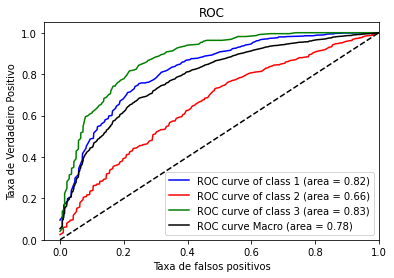

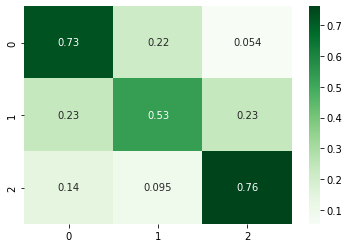

**********************0**********************
[100, 78, 27, 'adam', 0.0009867699768424754] -> accuracy:0.575 -> F1-Macro:0.5379225913234982recall score-macro:0.6169246031746032
**********************1**********************
[100, 82, 29, 'adam', 0.0009809434219293155] -> accuracy:0.5875 -> F1-Macro:0.531226256790304recall score-macro:0.6235218253968254
**********************2**********************
[93, 88, 27, 'adam', 0.0008383671820933087] -> accuracy:0.53125 -> F1-Macro:0.47255625033402815recall score-macro:0.6093987493987494
**********************3**********************
[92, 93, 28, 'adam', 0.0009380176844532386] -> accuracy:0.59375 -> F1-Macro:0.5390420610479293recall score-macro:0.6177873977873978
**********************4**********************
[85, 85, 29, 'adam', 0.0009557075297299129] -> accuracy:0.525 -> F1-Macro:0.4681194160849873recall score-macro:0.5664158476658477
**********************5**********************
[100, 98, 29, 'adam', 0.0009806217672681374] -> accuracy:0.5375 -> 

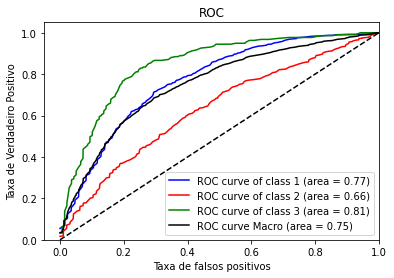

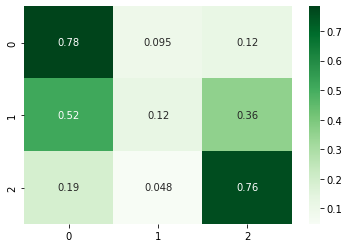

**********************0**********************
[85, 98, 27, 'adam', 0.0009667197802960742] -> accuracy:0.54375 -> F1-Macro:0.5095469984714105recall score-macro:0.5512797619047619
**********************1**********************
[62, 57, 28, 'adam', 0.0009826710846018352] -> accuracy:0.61875 -> F1-Macro:0.5675132394730044recall score-macro:0.6282341269841271
**********************2**********************
[65, 83, 29, 'adam', 0.0009377885713983838] -> accuracy:0.6125 -> F1-Macro:0.5958338264561406recall score-macro:0.6584607984607985
**********************3**********************
[90, 89, 30, 'adam', 0.0007669855079986349] -> accuracy:0.6375 -> F1-Macro:0.5885626596269825recall score-macro:0.6514381914381914
**********************4**********************
[82, 87, 28, 'adam', 0.0007325201311301238] -> accuracy:0.58125 -> F1-Macro:0.5650025232943146recall score-macro:0.6161061629811629
**********************5**********************
[89, 55, 29, 'adam', 0.0008822604570897895] -> accuracy:0.56875 ->

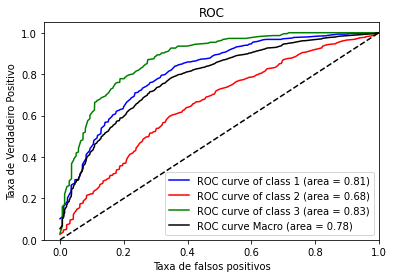

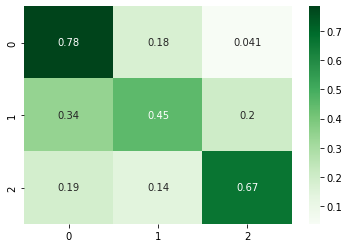

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []

  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            neurons1    = trial.suggest_int("neurons1", 50, 100)
            neurons2    = trial.suggest_int("neurons2", 50, 100)
            max_iter    = trial.suggest_int("max_iter", 10, 30)
            solver      = trial.suggest_categorical("solver", ['adam', 'sgd'])
            learning_rate_init   = trial.suggest_float("learning_rate_init", 0.0001, 0.001)


            #Modelo Utilizado -> MLP
            model = MLPClassifier(hidden_layer_sizes=(neurons1,neurons2), max_iter=max_iter,solver=solver, verbose=False,  learning_rate_init=learning_rate_init)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [neurons1,neurons2,max_iter,solver,learning_rate_init]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["neurons1"])
          h_1.append(Importance["neurons2"])
          h_2.append(Importance["max_iter"])
          h_3.append(Importance["solver"])
          h_4.append(Importance["learning_rate_init"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3
  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("neurons1: %.2f%%, neurons2: %.2f%%, max_iter: %.2f%%, solver: %.2f%%, learning_rate_init: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***SVM (Support Vector Machines)***

**********************0**********************
[8, 'rbf', 9.715014223692535] -> accuracy:0.725 -> F1-Macro:0.7112325602061672recall score-macro:0.7183035714285714
**********************1**********************
[9, 'rbf', 9.766318417036429] -> accuracy:0.68125 -> F1-Macro:0.6592507126964261recall score-macro:0.6856646825396826
**********************2**********************
[9, 'rbf', 9.407293549708971] -> accuracy:0.6875 -> F1-Macro:0.6992879976750944recall score-macro:0.7154785954785955
**********************3**********************
[4, 'rbf', 9.945889713767912] -> accuracy:0.73125 -> F1-Macro:0.7142502306436732recall score-macro:0.7144684944684944
**********************4**********************
[9, 'rbf', 9.26820474284269] -> accuracy:0.63125 -> F1-Macro:0.6153470185728249recall score-macro:0.6165924447174448
**********************5**********************
[7, 'rbf', 9.76004627314494] -> accuracy:0.6625 -> F1-Macro:0.6698402623505766recall score-macro:0.6780942874692876
**********************

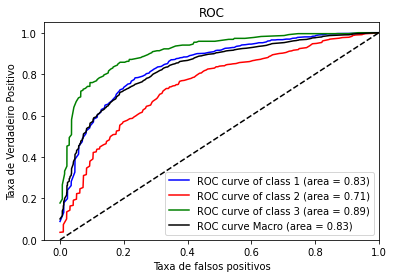

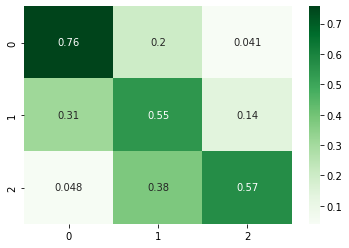

**********************0**********************
[1, 'rbf', 6.822571332715022] -> accuracy:0.475 -> F1-Macro:0.4318241318241318recall score-macro:0.5077083333333333
**********************1**********************
[4, 'linear', 1.6445845403801216] -> accuracy:0.575 -> F1-Macro:0.5275046505447781recall score-macro:0.6260615079365079
**********************2**********************
[10, 'rbf', 2.7178498299990235] -> accuracy:0.5625 -> F1-Macro:0.5318956893944681recall score-macro:0.6178258778258777
**********************3**********************
[3, 'rbf', 2.295279636787615] -> accuracy:0.65 -> F1-Macro:0.6035351194338866recall score-macro:0.6735738335738336
**********************4**********************
[1, 'rbf', 8.019879871361374] -> accuracy:0.4875 -> F1-Macro:0.4459667597965471recall score-macro:0.5010237510237511
**********************5**********************
[4, 'rbf', 2.7292987794571486] -> accuracy:0.575 -> F1-Macro:0.5316904263773334recall score-macro:0.5697174447174448
********************

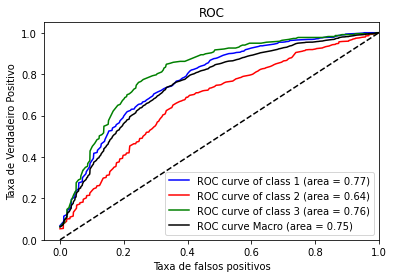

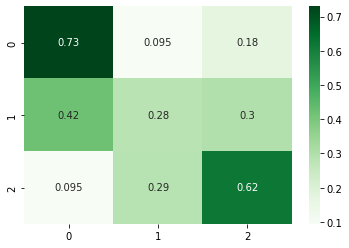

**********************0**********************
[5, 'rbf', 7.860714639980179] -> accuracy:0.70625 -> F1-Macro:0.6743985782077355recall score-macro:0.6889583333333333
**********************1**********************
[8, 'rbf', 9.277801161696281] -> accuracy:0.64375 -> F1-Macro:0.6162481097546032recall score-macro:0.6437499999999999
**********************2**********************
[10, 'rbf', 9.987261161269215] -> accuracy:0.66875 -> F1-Macro:0.6718417025805731recall score-macro:0.6790379990379991
**********************3**********************
[9, 'rbf', 9.220133009023487] -> accuracy:0.73125 -> F1-Macro:0.712297953019056recall score-macro:0.7209427609427609
**********************4**********************
[6, 'rbf', 9.3948703308182] -> accuracy:0.6125 -> F1-Macro:0.6066762948598104recall score-macro:0.6194461506961506
**********************5**********************
[7, 'rbf', 9.334577152780604] -> accuracy:0.6875 -> F1-Macro:0.6937568782098312recall score-macro:0.7053516584766584
********************

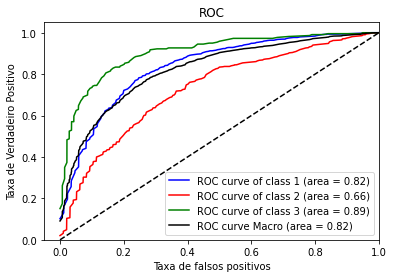

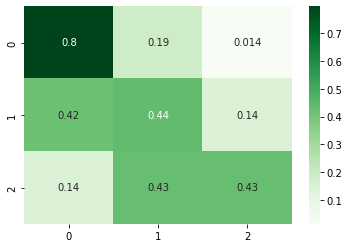

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []


  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            C = trial.suggest_int("C", 1, 10)
            kernel     = trial.suggest_categorical("kernel", ['linear','rbf', 'sigmoid'])
            gamma   = trial.suggest_float("gamma", 0.1, 10)

            #Modelo Utilizado -> SVN
            model = SVC(C=C, kernel=kernel, gamma=gamma,  random_state=0, probability=True)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [C, kernel, gamma]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["C"])
          h_1.append(Importance["kernel"])
          h_2.append(Importance["gamma"])

          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("C: %.2f%%, kernel: %.2f%%, gamma: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()